# AGU 2021

## Data Prep

In [1]:
import xarray as xa
import pandas as pd
from datetime import datetime, date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from genetic_algorithm import genetic_algorithm
from keras_visualizer import visualizer

In [2]:
df = pd.read_csv('./32_STEVE_EVENTS_Labeled_df.csv')
df.head(10)

,Unnamed: 0,By,Bz,PC1,PC2,PC3,PC4,SML,cpcp,hour,time,hourbin,event
0,0,-1.67,3.42,64653.004077,-160358.825318,-47353.417436,39646.871925,-116.0,32.291413,-1.200000,2008-02-11 08:00:00,-1.25,1
1,1,-3.18,2.92,102649.640291,-185430.396101,-45396.211333,3023.915222,-125.0,29.960107,-1.116667,2008-02-11 08:05:00,-1.00,1
2,2,-3.41,2.75,161835.469554,-166707.536381,-19485.696443,-6327.593162,-94.0,26.918939,-1.033333,2008-02-11 08:10:00,-1.00,1
3,3,-2.03,2.74,199768.528492,-179418.730394,-10756.192864,-31623.419630,-125.0,23.472209,-0.950000,2008-02-11 08:15:00,-1.00,1
4,4,-0.98,3.60,205430.249457,-153430.863222,837.938185,-5341.239062,-60.0,16.059939,-0.866667,2008-02-11 08:20:00,-0.75,1
5,5,-1.97,2.79,164000.429474,-168152.728636,-3507.392011,-1415.432512,-60.0,17.826138,-0.783333,2008-02-11 08:25:00,-0.75,1
6,6,-1.04,1.72,199026.704485,-149993.688634,-5979.775528,-4165.377081,-53.0,16.332872,-0.700000,2008-02-11 08:30:00,-0.75,1
7,7,-0.36,0.91,217921.261187,-153637.970165,8227.489723,-10762.291475,-208.0,14.661210,-0.616667,2008-02-11 08:35:00,-0.50,1
8,8,0.17,-0.48,198457.200588,-162027.568209,23929.696916,-27709.399973,-210.0,14.249256,-0.533333,2008-02-11 08:40:00,-0.50,1
9,9,-0.55,-3.35,197921.049353,-151450.095445,29808.295028,-27652.938049,-217.0,15.308488,-0.450000,2008-02-11 08:45:00,-0.50,1


1637


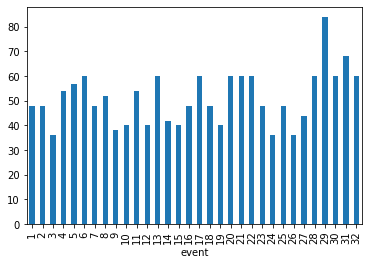

In [3]:
print(len(df))
df.groupby('event').size().plot.bar(y='event')

1574


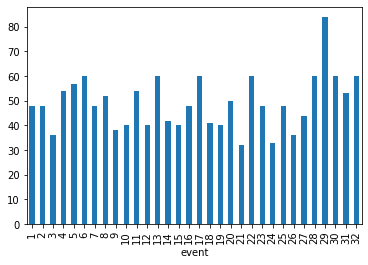

In [4]:
df_test = df[df['By'].notna()]
df_test = df_test[df_test['Bz'].notna()]
print(len(df_test))
df_test.groupby('event').size().plot.bar(y='event')

In [5]:
# TODO: plot which times are missing from each event, can make this a bit more formatted but the idea is here
'''
def plot_event_notna(ax, event):
    rows = df.loc[df['event'] == event]
    notna = rows['By'].notna()
    # TODO: turn on 
    ax.plot(rows['time'], notna)
    ax.set_title('notna for %s' % event)
    
fig, axs = plt.subplots(16, 2, figsize=(16, 50))
fig.tight_layout(h_pad=2, w_pad=5)
for i, ax in enumerate(axs.flat):
    event = i + 1
    plot_event_notna(ax, event)
'''

"\ndef plot_event_notna(ax, event):\n    rows = df.loc[df['event'] == event]\n    notna = rows['By'].notna()\n    # TODO: turn on \n    ax.plot(rows['time'], notna)\n    ax.set_title('notna for %s' % event)\n    \nfig, axs = plt.subplots(16, 2, figsize=(16, 50))\nfig.tight_layout(h_pad=2, w_pad=5)\nfor i, ax in enumerate(axs.flat):\n    event = i + 1\n    plot_event_notna(ax, event)\n"

In [6]:
# TODO: dangerous
df = df_test

In [7]:
def to_datetime(s):
    year = int(s[0:4])
    month = int(s[5:7])
    day = int(s[8:10])
    hour = int(s[11:13])
    minute = int(s[14:16])
    second = int(s[17:19]) 
    return datetime(year, month, day, hour, minute, second)
df_times = [to_datetime(el) for el in df['time']]

In [8]:
ds = xa.Dataset(data_vars={
    "al": xa.DataArray(
       data=df['SML'],
       dims='time',
       coords={
            'time': df_times,
        }
    
    ),
    "pc1": xa.DataArray(
        data=df['PC1'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "pc2": xa.DataArray(
        data=df['PC2'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "pc3": xa.DataArray(
        data=df['PC3'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "pc4": xa.DataArray(
        data=df['PC4'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "event": xa.DataArray(
        data=df['event'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "cpcp": xa.DataArray(
        data=df['cpcp'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "by": xa.DataArray(
        data=df['By'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "bz": xa.DataArray(
        data=df['Bz'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "hour": xa.DataArray(
        data=df['hour'],
        dims='time',
        coords={
            'time': df_times,
        }
    )
})

## Splitting the data

In [9]:
events = np.array([i for i in range(1, 33)])
events

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [10]:
# Random
shuffled_events = np.random.permutation(events)
train = shuffled_events[:22]
valid = shuffled_events[22:29]
test = shuffled_events[29:]
# Preselected
# TODO:
train, valid, test

(array([ 6, 12,  7, 17, 23, 32, 25,  3, 16, 21, 26, 15, 28,  4, 22,  5, 11,
        29, 24, 19, 13,  9]),
 array([31, 30, 27, 18, 10,  8, 14]),
 array([20,  2,  1]))

In [11]:
valid = np.array([9, 21, 29, 6, 27, 1, 23])
test = np.array([13, 30, 14])
train = np.array(np.setdiff1d(events, np.concatenate((valid, test))))
print('Train Events: %s' % train)
print('Valid Events: %s' % valid)
print('Test Events: %s' % test)

Train Events: [ 2  3  4  5  7  8 10 11 12 15 16 17 18 19 20 22 24 25 26 28 31 32]
Valid Events: [ 9 21 29  6 27  1 23]
Test Events: [13 30 14]


## Creating our data

In [12]:
def get_variable_indices(variables):
    t = {
        'al': 0,
        'pc1': 1,
        'pc2': 2,
        'pc3': 3, 
        'pc4': 4,
        'event': 5,
        'cpcp': 6,
        'by': 7,
        'bz': 8,
        'hour': 9
    }
    return [(key in variables) for key in t]

def get_indices(event_type):
    return ds['event'].isin(event_type).values.flatten()

def get_data(data_vars, event_type):
    return da.loc[get_indices(event_type)][:, get_variable_indices(data_vars)]

In [13]:
da = ds.to_array().T
da

<xarray.DataArray (time: 1574, variable: 10)>
array([[-1.16000000e+02,  6.46530041e+04, -1.60358825e+05, ...,
        -1.66999996e+00,  3.42000008e+00, -1.20000000e+00],
       [-1.25000000e+02,  1.02649640e+05, -1.85430396e+05, ...,
        -3.18000007e+00,  2.92000008e+00, -1.11666667e+00],
       [-9.40000000e+01,  1.61835470e+05, -1.66707536e+05, ...,
        -3.41000009e+00,  2.75000000e+00, -1.03333333e+00],
       ...,
       [-9.40000000e+01,  2.25964111e+05, -1.51069214e+05, ...,
         7.09999979e-01,  4.73999977e+00,  3.88333333e+00],
       [-7.80000000e+01,  2.05279772e+05, -1.16872714e+05, ...,
         2.59999990e-01,  4.19999981e+00,  3.96666667e+00],
       [-8.80000000e+01,  2.22009057e+05, -1.58579067e+05, ...,
         4.30000007e-01,  4.19999981e+00,  4.05000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2008-02-11T08:00:00 ... 2018-07-17T09:25:00
  * variable  (variable) <U5 'al' 'pc1' 'pc2' 'pc3' ... 'cpcp' 'by' 'bz' 'hour'

In [14]:
event = ds['event']
da = da.assign_coords(event=('time', event))
da

<xarray.DataArray (time: 1574, variable: 10)>
array([[-1.16000000e+02,  6.46530041e+04, -1.60358825e+05, ...,
        -1.66999996e+00,  3.42000008e+00, -1.20000000e+00],
       [-1.25000000e+02,  1.02649640e+05, -1.85430396e+05, ...,
        -3.18000007e+00,  2.92000008e+00, -1.11666667e+00],
       [-9.40000000e+01,  1.61835470e+05, -1.66707536e+05, ...,
        -3.41000009e+00,  2.75000000e+00, -1.03333333e+00],
       ...,
       [-9.40000000e+01,  2.25964111e+05, -1.51069214e+05, ...,
         7.09999979e-01,  4.73999977e+00,  3.88333333e+00],
       [-7.80000000e+01,  2.05279772e+05, -1.16872714e+05, ...,
         2.59999990e-01,  4.19999981e+00,  3.96666667e+00],
       [-8.80000000e+01,  2.22009057e+05, -1.58579067e+05, ...,
         4.30000007e-01,  4.19999981e+00,  4.05000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2008-02-11T08:00:00 ... 2018-07-17T09:25:00
  * variable  (variable) <U5 'al' 'pc1' 'pc2' 'pc3' ... 'cpcp' 'by' 'bz' 'hour'
    event     (time) int64 1 1 1 1 1 1 1 1 1 1 ... 32 32 32 32 32 32 32 32 32 32

In [15]:
def split(features, pred):
    X_train, X_valid, X_test = get_data(features, train), get_data(features, valid), get_data(features, test)
    Y_train, Y_valid, Y_test = get_data(pred, train), get_data(pred, valid), get_data(pred, test)
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test 

In [16]:
def create_scaler(d):
    """
    scaler.transform(d) => scale
    scaler.inverse_transform(d) => unscale
    """
    scaler = RobustScaler()
    scaler.fit(d)
    return scaler

In [17]:
def scale(d, scaler):
    scaled = scaler.transform(d)
    new_d = xa.DataArray(
        data=scaled,
        dims=['time', 'feature'],
        coords={
            'time': d.time
        }
    )
    new_d = new_d.assign_coords(event=('time', d.event))
    return new_d
    
def unscale(d, scaler):
    unscaled = scaler.inverse_transform(d)
    new_d = xa.DataArray(
        data=unscaled,
        dims=['time', 'feature'],
        coords={
            'time': d.time
        }
    )
    new_d = new_d.assign_coords(event=('time', d.event))
    return new_d

In [18]:
def window_Y(data, time_steps=0):
    spec_events = np.unique(data.event)
    
    new, times, events = [], [], []
    
    for e in spec_events:
        temp = data.loc[data.event ==  e]
        for i in range(time_steps, len(temp)):
            new.append(temp[i])
            times.append(temp[i].time.values)
            events.append(temp[i].event.values)
    new_da = xa.DataArray(
        data=new,
        dims=['time', 'features'],
        coords={
            'time': times 
        }
    )
    new_da = new_da.assign_coords(event=('time', events))
    return new_da
    
def window_X(data, time_steps=0):
    # dim1 = batch
    # dim2 = time
    # dim3 = feature
    spec_events = np.unique(data.event)
    
    new = []
    times = []
    events = []
    
    batch_events = []
    
    for e in spec_events:
        temp = data.loc[data.event == e]
        for i in range(time_steps, len(temp)):
            new.append([el for el in temp[i-time_steps:i+1].values])
            times.append([el for el in temp.time[i-time_steps:i+1].values])
            events.append([el for el in temp.event[i-time_steps:i+1].values])
            # special case for multiple time steps back, time not as important
            batch_events.append(e)
    new = np.array(new)
    times = np.array(times)
    events = np.array(events)
    batch_events = np.array(batch_events)
    if (time_steps == 0):
        new = new[:, 0, :]
        times = times[:, 0]
        events = events[:, 0]
        new_da = xa.DataArray(
            data=new,
            dims=['time', 'features'],
            coords={
                'time': times
            }
        )
        new_da = new_da.assign_coords(event=('time', events))
        return new_da
    else:  
        new_da = xa.DataArray(
            data=new,
            dims=['batch', 'time', 'features']
        )
        new_da = new_da.assign_coords(event=('batch', batch_events))
        return new_da

In [19]:
def predict(model, x, times, events):
    try:
        y = model.predict(x.values)
    except:
        y = model.predict(x)
    new_d = xa.DataArray(
        data=y,
        # NOTE: feature is not used here, but needed for [time, 1] shape
        dims=['time', 'feature'],
        coords={
            'time': times
        }
    )
    new_d = new_d.assign_coords(event=('time', events))
    return new_d

With the above functions, it should be fairly easy to create a model and its correct inputs/outputs

## Genetic Algorithm

In [20]:
loss_fn = tf.losses.MeanSquaredError() # NOTE: this is the best one!

In [21]:
pool = {
    'al': [0, 1], 
    'by': [0, 1], 
    'bz': [0, 1], 
    'hour': [0, 1],
    'time_lag': [0, 1, 2, 3, 4, 5, 6, 7],
    'layer_1_units': [4, 8, 12, 16, 32, 48, 64], # NOTE: layer 1 cannot be 0
    'layer_2_units': [0, 4, 8, 12, 16, 32, 48, 64],
    'layer_3_units': [0, 4, 8, 12, 16, 32, 48, 64],
    'layer_4_units': [0, 4, 8, 12, 16, 32, 48, 64]
}

def generate_model(genes):
    model = Sequential()
    if (genes['time_lag'] != 0):
        model.add(LSTM(units=genes['layer_1_units']))
    else:
        model.add(Dense(units=genes['layer_1_units'], activation='relu'))
    if (genes['layer_2_units'] != 0):
        model.add(Dense(units=genes['layer_2_units'], activation='relu'))
    if (genes['layer_3_units'] != 0):
        model.add(Dense(units=genes['layer_3_units'], activation='relu'))
    if (genes['layer_4_units'] != 0):
        model.add(Dense(units=genes['layer_4_units'], activation='relu'))
    model.add(Dense(units=1))
    return model
    
def compile_and_fit(model, X_train, Y_train, patience=2, epochs=20):

    model.compile(loss=loss_fn,
                optimizer=tf.optimizers.Adam())

    history = model.fit(X_train, Y_train, epochs=epochs, verbose=0)
    return history

def fill_member(member, epochs): 
    lags = member['genes']['time_lag']
    
    pred = 'pc3'
    
    features = []
    (features.append('al') if member['genes']['al'] == 1 else None)
    (features.append('by') if member['genes']['by'] == 1 else None)
    (features.append('bz') if member['genes']['bz'] == 1 else None)
    (features.append('hour') if member['genes']['hour'] == 1 else None)
    
    # NOTE: if no features included in genes, force a mutation and include one feature
    if len(features) == 0:
        c = np.random.choice(['al', 'by', 'bz', 'hour'])
        member['genes'][c] = 1
        features.append(c)
   
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split(features, pred)
    
    member['X_scaler'] = create_scaler(X_train) 
    member['Y_scaler'] = create_scaler(Y_train)
    
    member['train'] = {}
    member['train']['X'] = scale(X_train, member['X_scaler'])
    member['train']['Y'] = scale(Y_train, member['Y_scaler'])
    member['valid'] = {}
    member['valid']['X'] = scale(X_valid, member['X_scaler'])
    member['valid']['Y'] = scale(Y_valid, member['Y_scaler'])
    member['test'] = {}
    member['test']['X'] = scale(X_test, member['X_scaler'])
    member['test']['Y'] = scale(Y_test, member['Y_scaler'])
    
    member['train']['X'] = window_X(member['train']['X'], lags) 
    member['train']['Y'] = window_Y(member['train']['Y'], lags) 
    member['valid']['X'] = window_X(member['valid']['X'], lags) 
    member['valid']['Y'] = window_Y(member['valid']['Y'], lags) 
    member['test']['X'] = window_X(member['test']['X'], lags) 
    member['test']['Y'] = window_Y(member['test']['Y'], lags) 
    
    member['model'] = generate_model(member['genes'])
    hist = compile_and_fit(member['model'], member['train']['X'].values, member['train']['Y'].values, epochs=epochs)
    # TODO: can turn verbose=0 below
    member['val_loss'] = member['model'].evaluate(member['valid']['X'].values, member['valid']['Y'].values, verbose=0)

In [22]:
# TODO: see why epochs seems to not be working
hist, best_member = genetic_algorithm(pool, size=20, generations=4, fill_member=fill_member)

11/11 [==============================] - 0s 816us/step - loss: 0.6311
Initial Population Generated
10/10 [==============================] - 0s 1ms/step - loss: 0.4944
Generation 1 complete
11/11 [==============================] - 0s 1ms/step - loss: 0.6423
Generation 2 complete
11/11 [==============================] - 0s 930us/step - loss: 0.6156
Generation 3 complete
11/11 [==============================] - 0s 865us/step - loss: 0.5479
Generation 4 complete


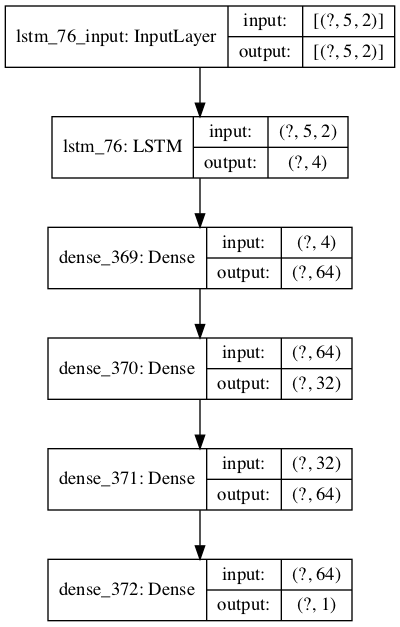

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(best_member['model'], show_shapes=True)

In [24]:
best_member['genes']

{'al': 1,
 'by': 0,
 'bz': 1,
 'hour': 0,
 'time_lag': 4,
 'layer_1_units': 4,
 'layer_2_units': 64,
 'layer_3_units': 32,
 'layer_4_units': 64}

In [25]:
print('Test Loss: %s (Mean Squared Error)' % best_member['model'].evaluate(best_member['test']['X'].values, best_member['test']['Y'].values, verbose=0))
print('Validation Loss: %s (Mean Squared Error)' % best_member['model'].evaluate(best_member['valid']['X'].values, best_member['valid']['Y'].values, verbose=0))

Test Loss: 0.27848732471466064 (Mean Squared Error)
Validation Loss: 0.5382332801818848 (Mean Squared Error)


## Plotting

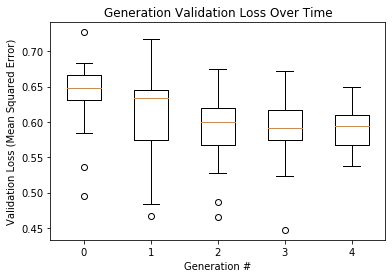

In [26]:
def plot_generation_fitness(ax, history):
    d = []
    gens = []
    for g in range(len(history)):
        gens.append(g)
        d.append(history[g]['fitness'])
    ax.boxplot(d, positions=gens)
    ax.set_ylabel('fitness')
    ax.set_xlabel('generation')
    ax.set_title('Generation fitness over time')
    
def plot_generation_val_loss(ax, history):
    d = []
    gens = []
    for g in range(len(history)):
        gens.append(g)
        d.append(history[g]['val_loss'])
    ax.boxplot(d, positions=gens)
    ax.set_ylabel('Validation Loss (Mean Squared Error)')
    ax.set_xlabel('Generation #')
    ax.set_title('Generation Validation Loss Over Time')
    
fig, ax = plt.subplots()
plot_generation_val_loss(ax, hist)

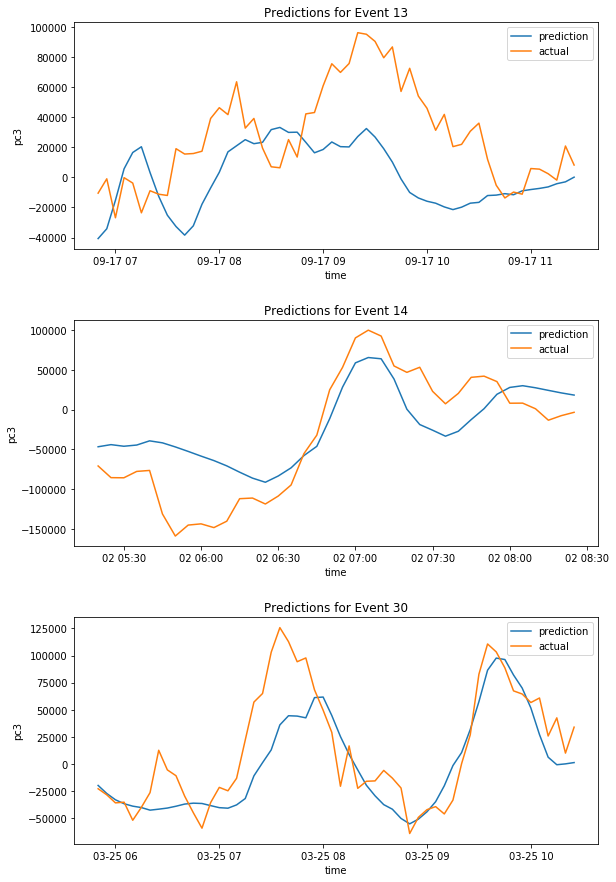

In [27]:
def plot_event_pred(ax, p, y, event_num):
    ax.plot(y.time, p, label='prediction')
    ax.plot(y.time, y, label='actual')
    ax.set_xlabel('time')
    ax.set_ylabel('pc3') # TODO: get units here
    ax.set_title('Predictions for Event %s' % event_num)
    ax.legend()

def plot_test_events(member):
    # get each test event
    events = np.unique(member['test']['Y'].event)
    
    # plot
    fig, axs = plt.subplots(len(events), figsize=(8, (4 * len(events))))
    fig.tight_layout(h_pad=5)
    for i in range(0, len(events)):
        ax = axs[i]
        event_num = events[i]
        X_test = member['test']['X'].loc[member['test']['X'].event == event_num]
        Y_test = member['test']['Y'].loc[member['test']['Y'].event == event_num]
        pred = predict(member['model'], X_test, Y_test.time, Y_test.event)
        pred = unscale(pred, member['Y_scaler'])
        y = unscale(Y_test, member['Y_scaler'])
        plot_event_pred(ax, pred, y, event_num)
    return fig
    
fig = plot_test_events(best_member)

## Map Reconstruction

This has proven more troublesome than originall anticipated

In [ ]:
import h5py 
df_all = pd.read_csv('./32_STEVE_EVENTS_Labeled_df.csv')

event_means = {
}

def amgeo_time_to_datetime(s):
    y = int(s[0:4])
    m = int(s[4:6])
    d = int(s[6:8])
    h = int(s[9:11])
    mn = int(s[12:14])
    s = 0
    return datetime(y, m, d, h, mn, s)

datetime_to_event = {
}
for i in range(0, len(df_all)):
    datetime_to_event[to_datetime(df_all['time'][i])] = df_all['event'][i]
    
event_maps = {
}
for i in range(1, 33):
    event_maps[i] = []

# compile
lats, lons = None, None
with h5py.File('Updated_32_STEVEEvents.h5', 'r') as f:
    keys = list(f.keys())
    for k in keys[0:-2]:
        t = amgeo_time_to_datetime(k)
        event = datetime_to_event[t]
        arr = np.array(f[k]).reshape(24, 37)
        event_maps[event].append(arr)
    lats = np.array(f['lats']).reshape(24, 37)
    lons = np.array(f['lons']).reshape(24, 37)
    
for i in range(1, 33):
    event_means[i] = np.mean(np.array(event_maps[i]), axis=0)


In [ ]:
import pickle
pc3 = None
with open('PC3_{}_dict.pkl'.format('STEVE'), 'rb') as file:
    d = pickle.load(file)
    pc3 = d['PC3'].reshape(24, 37)
print(pc3.shape)

In [ ]:
def PC3_reconstruct(epot_mean, weight_3):
    epot = epot_mean + (weight_3 * pc3.reshape(24, 37))
    return epot * 1000

def polar2dial(ax):
    #Rotate the plot so that noon is at the top and midnight
    #is at the bottom, and fix the labels so radial direction
    #is latitude and azimuthal direction is local time in hours
    ax.set_theta_zero_location('S')
    theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
    theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
    ax.set_thetagrids(theta_label_values,labels=theta_labels)

    r_label_values = 90.-np.array([80.,70.,60.,50.,40.])
    r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
    ax.set_rgrids(r_label_values,labels=r_labels)

def plot_reconstruction(ax, epot):
    polar2dial(ax)
    r = np.radians(90.-lats)
    th = np.radians(lons)
    ax.contourf(th,r,epot,50,cmap='RdBu_r')
    return ax

In [ ]:
i = 50 
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121, projection='polar')
ax2 = fig.add_subplot(122, projection='polar')
e = best_member['test']['Y'].event.values[i]
y = best_member['test']['Y'][i]
p = predict(best_member['model'], best_member['test']['X'], best_member['test']['Y'].time, best_member['test']['Y'].event)[i]

prediction = PC3_reconstruct(event_means[e], p.values * 1000)
actual = PC3_reconstruct(event_means[e], y.values)
vmax = np.max(actual)

plot_reconstruction(ax1, prediction)
plot_reconstruction(ax2, actual)